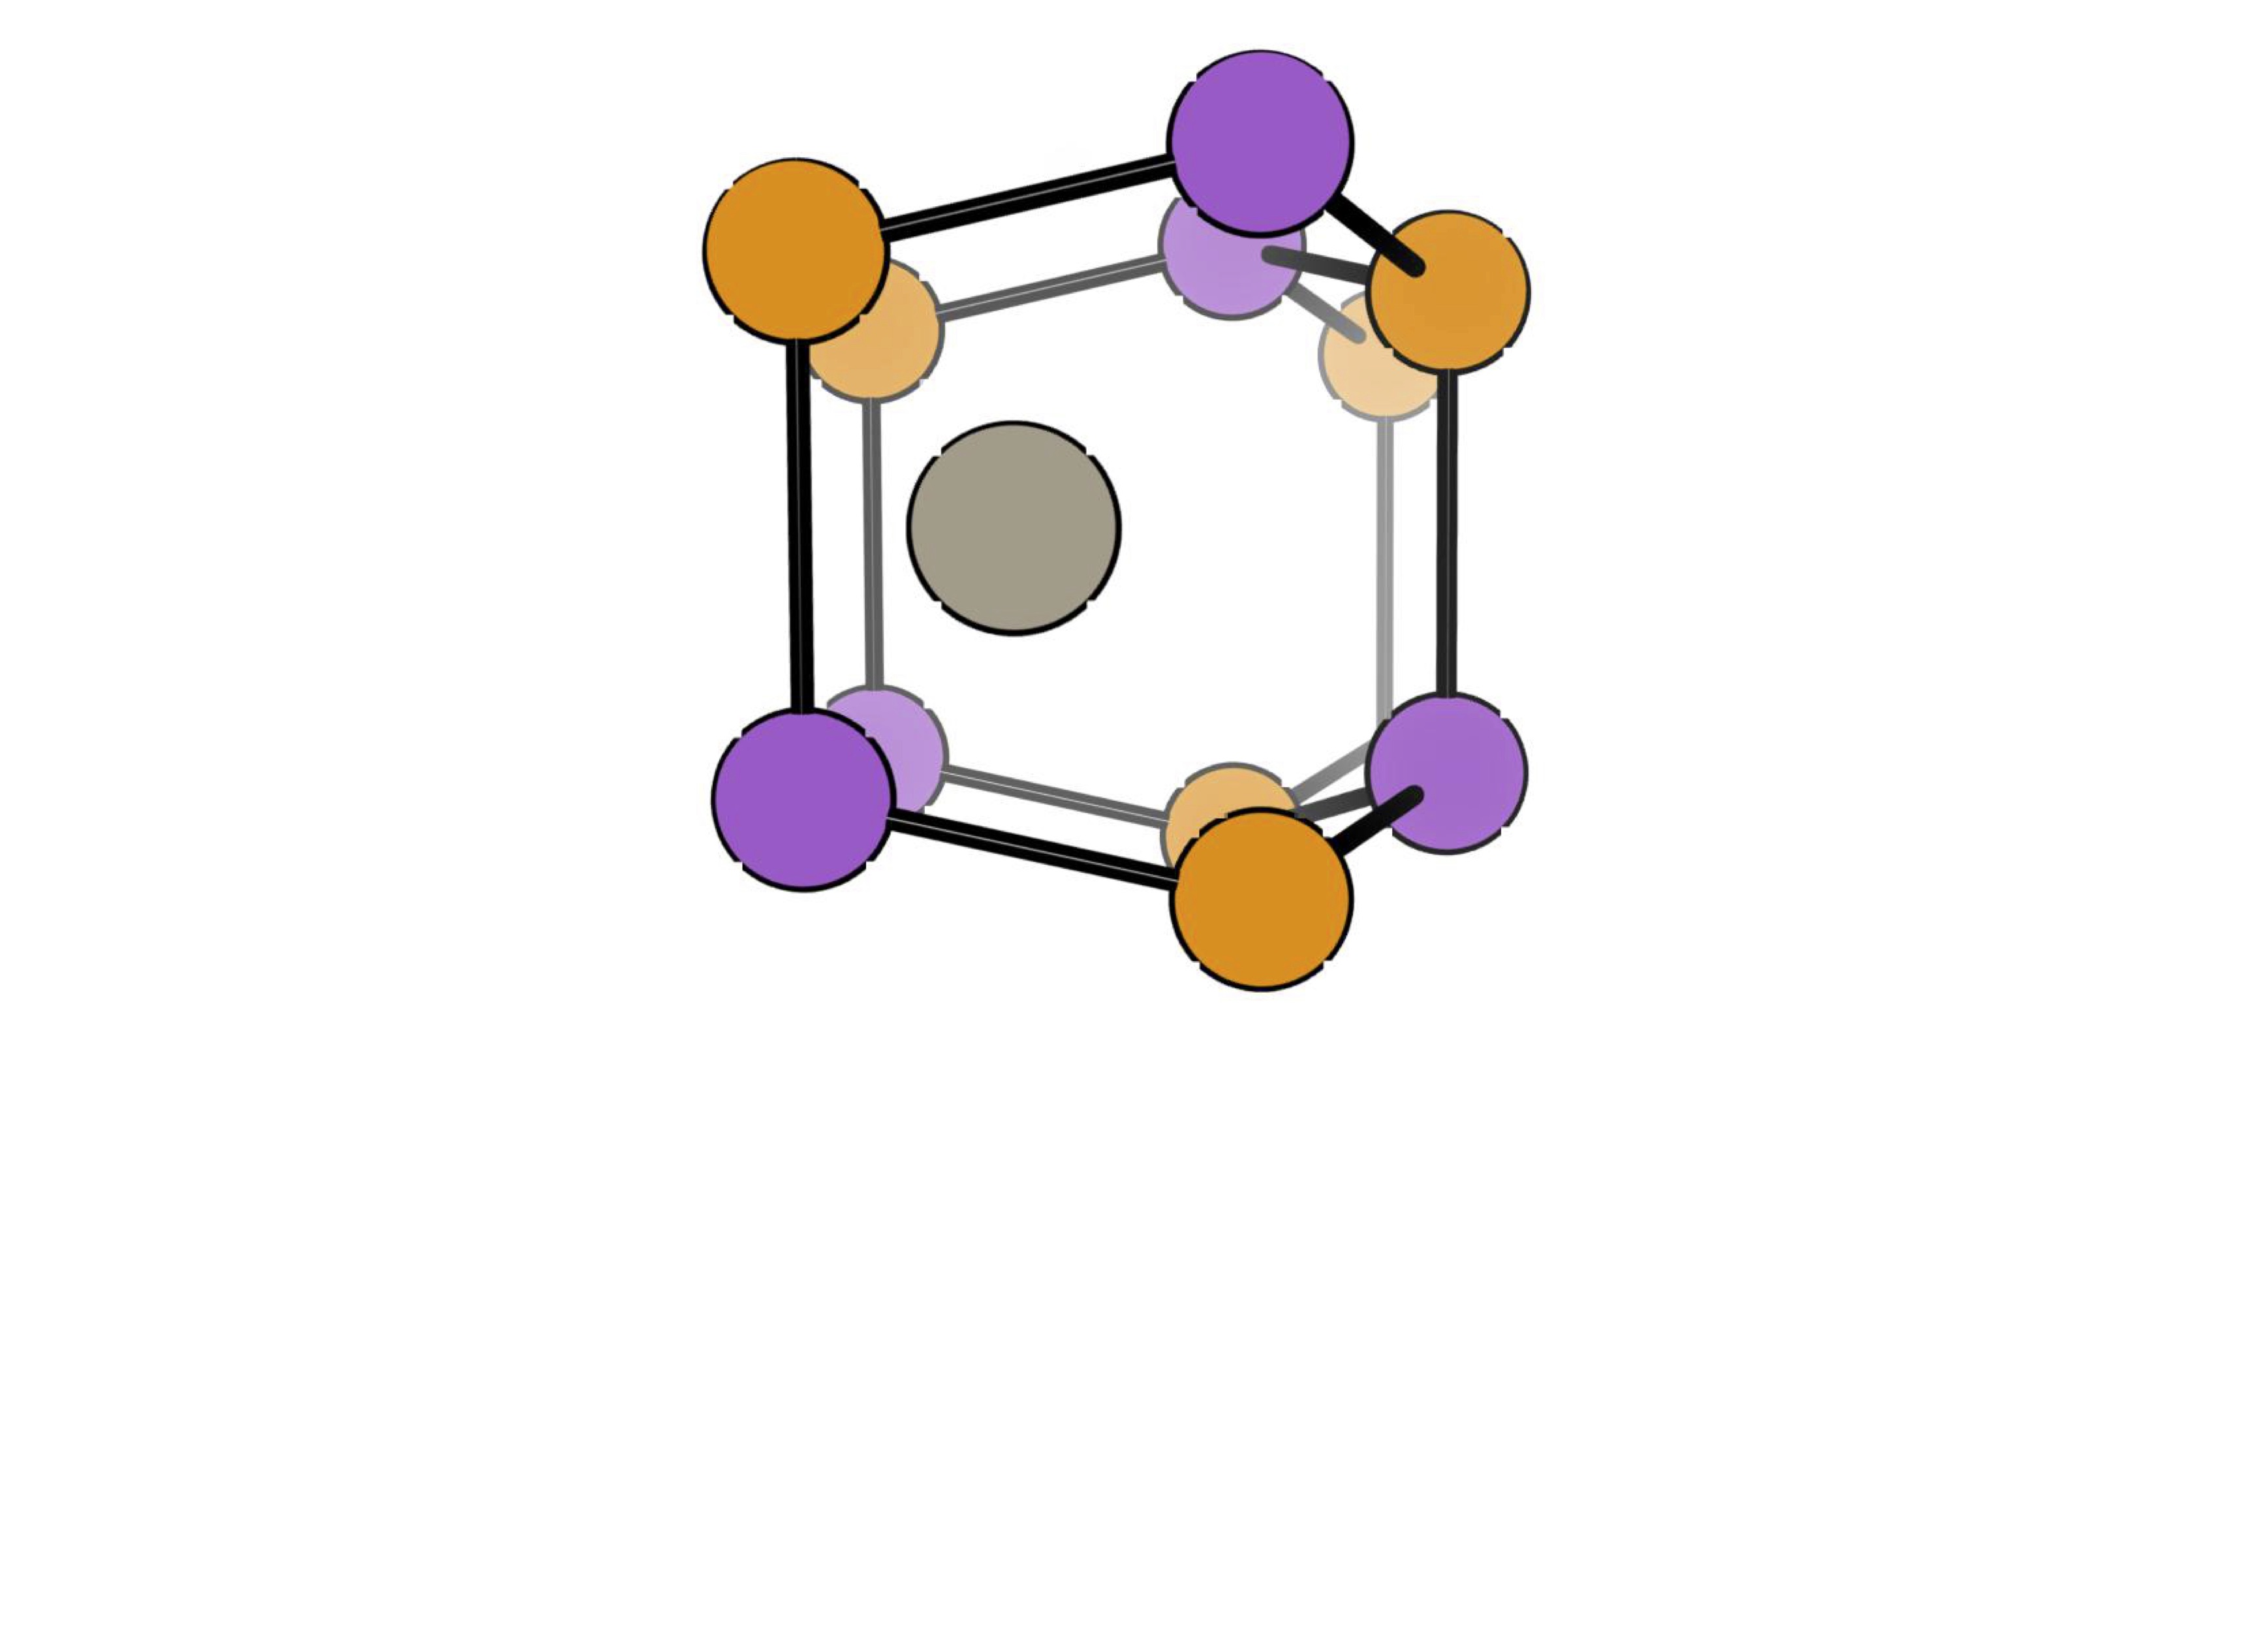

In [45]:
from IPython.display import Image
Image('Figures/Cage.jpg',width=500)

##Enumerating the number of possible "stuffed wurtzite" hybrid materials with methyl-ammonium

### Dependancies

hinton_colour is a script for generating coloured Hinton plots. This given in this directory for the sake of the example.

### Background

Based on Phys. Rev. Lett. 109, 167602 (2012) http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.109.167602

I have estimated a tolerance factor (a la Goldschmidt ratio) for these structures, based on the existing structures in the ICSD.
The formula is:

$ t = \frac{r_a}{pore}$

$r_a$ is the radius of the stuffing element and the pore size is calculated from the radii of the framework elements.

$pore = \frac{r_b+r_c \sin 109.5}{\sin 30.25}$



The $r_a$ chosen is that of MA as published in Chem. Sci., 2014, 5, 4712-4715 http://pubs.rsc.org/en/content/articlehtml/2014/sc/c4sc02211d

The environmental and sustainability aspects of the materials are estimated using the Herfindahl–Hirschman Index (HHI), which estimates production and reserve stability, reliability and sustainability. The numbers used were published in Chem. Mater., 2013, 25 (15), pp 2911–2920 http://pubs.acs.org/doi/abs/10.1021/cm400893e

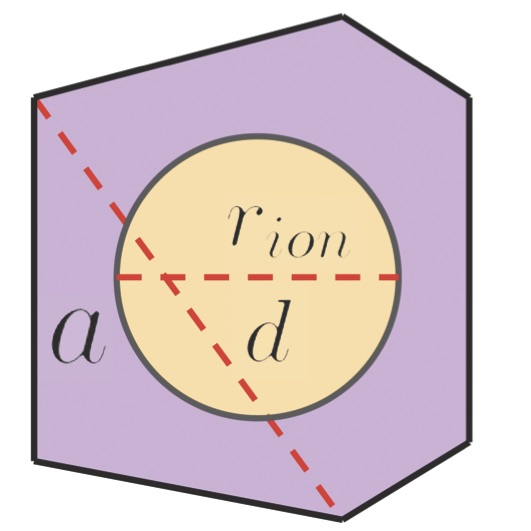

In [46]:
Image('Figures/Tolerance.jpg', width=200)

In [47]:
%load_ext autoreload
%autoreload 2
import smact
import smact.lattice_parameters as lattice_parameters
import smact.properties.Band_gap_simple as band_gap
import numpy as np
from os import path
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import hinton_colour as hinton
from ase.lattice.spacegroup import crystal
import ase.io.vasp as io

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define the starting parameters
* We will search over elements 1 - 100
* The charge of the framework should be -1, to counterbalance the +1 of the MA ion.

In [48]:
lattice_charge=-1
upper_n = 37
lower_n = 3

all_elements=[]
element_set= smact.ordered_elements(lower_n,upper_n)

### Take elemetns with tetrahedral known bonding environments

In [49]:
tetra_coord=[]
for element in element_set:
    with open(path.join(smact.data_directory, 'shannon_radii.csv'), 'rU') as f:
        reader = csv.reader(f)
        r_shannon=False
        for row in reader:
            if row[2]=="4_n" and row[0]==element and row[0] not in tetra_coord_elements:
                tetra_coord.append(row[0])
                
tetra_coord_elements = smact.element_dictionary(tetra_coord_elements)

### Set up grids to hold the collected data
* HHI Production
* HHI Reservs
* Band gap (estimated from tight-binding)
* Tolerance factor

In [50]:
HHIp_grid = np.zeros(shape=(upper_n-lower_n,upper_n-lower_n))
Tol_grid  = np.zeros(shape=(upper_n-lower_n,upper_n-lower_n))
Eg_grid   = np.zeros(shape=(upper_n-lower_n,upper_n-lower_n))
HHIr_grid = np.zeros(shape=(upper_n-lower_n,upper_n-lower_n))

all_elements=[]
element_set=smact.ordered_elements(lower_n,upper_n)

### Now calculate the tolerance factor and HHI for production
* Also check that the framework charge is -1

In [51]:
list_of_candidates = []
HP_cut  = 2900
HR_cut  = 4900
tol_cut = 0.78
Eg_cut  = 4.5
for a_element in tetra_coord_elements:
    for a_ox in tetra_coord_elements[a_element].oxidation_states:
        for b_element in tetra_coord_elements:
            for b_ox in tetra_coord_elements[b_element].oxidation_states:
                    if b_ox + a_ox == -1:
                        radius_a = tetra_coord_elements[a_element].covalent_radius*100
                        radius_b = tetra_coord_elements[b_element].covalent_radius*100
                        pore = (radius_a + radius_b)*np.sin(np.radians(109.5))\
                        /np.sin(np.radians(30.25))
                        tolerance = 217*2/pore
                        HHI_prod = (tetra_coord_elements[a_element].HHI_p \
                        + tetra_coord_elements[b_element].HHI_p + 900.)/3.
                        HHIp_grid[tetra_coord_elements[a_element].number-lower_n,tetra_coord_elements[b_element].number-lower_n] = \
                        HHI_prod
                        Tol_grid[tetra_coord_elements[a_element].number-lower_n,tetra_coord_elements[b_element].number-lower_n] = \
                        tolerance
                        sep = \
                        tetra_coord_elements[a_element].covalent_radius+tetra_coord_elements[b_element].covalent_radius
                        if a_ox < b_ox: # A is the anion
                            Eg = band_gap.band_gap_simple(Anion=a_element,Cation=b_element,Distance=sep)
                        else:
                            Eg = band_gap.band_gap_simple(Anion=b_element,Cation=a_element,Distance=sep)
                        HHI_res = (tetra_coord_elements[a_element].HHI_R \
                        + tetra_coord_elements[b_element].HHI_R + 900)/3
                        HHIr_grid[tetra_coord_elements[b_element].number-lower_n,tetra_coord_elements[a_element].number-lower_n] = \
                        HHI_res
                        Eg_grid[tetra_coord_elements[b_element].number-lower_n,tetra_coord_elements[a_element].number-lower_n] = \
                        Eg
                        if HHI_prod <= HP_cut and HHI_res <= HR_cut and Eg <= Eg_cut and tolerance <= tol_cut:
                            list_of_candidates.append(['Cs', tetra_coord_elements[a_element].symbol, tetra_coord_elements[b_element].symbol])
print list_of_candidates

[['Cs', 'Na', 'Fe'], ['Cs', 'Na', 'Mn'], ['Cs', 'Na', 'Cr'], ['Cs', 'Ti', 'Mn'], ['Cs', 'Ti', 'Cr'], ['Cs', 'Ti', 'Mn'], ['Cs', 'Ge', 'K'], ['Cs', 'Fe', 'Na'], ['Cs', 'Fe', 'K'], ['Cs', 'K', 'Ge'], ['Cs', 'K', 'Fe'], ['Cs', 'K', 'Mn'], ['Cs', 'K', 'P'], ['Cs', 'K', 'S'], ['Cs', 'K', 'Se'], ['Cs', 'K', 'Si'], ['Cs', 'K', 'Cr'], ['Cs', 'Mn', 'Ti'], ['Cs', 'Mn', 'Na'], ['Cs', 'Mn', 'Ti'], ['Cs', 'Mn', 'K'], ['Cs', 'P', 'K'], ['Cs', 'S', 'K'], ['Cs', 'Se', 'K'], ['Cs', 'Si', 'K'], ['Cs', 'Cr', 'Na'], ['Cs', 'Cr', 'Ti'], ['Cs', 'Cr', 'K']]


### Plot a 2D grid of HHI production and estimated band gap
* The grid plotting uses a Hinton plot module I wrote

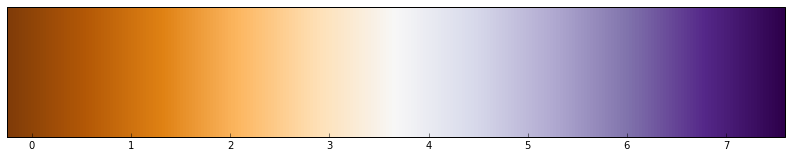

34


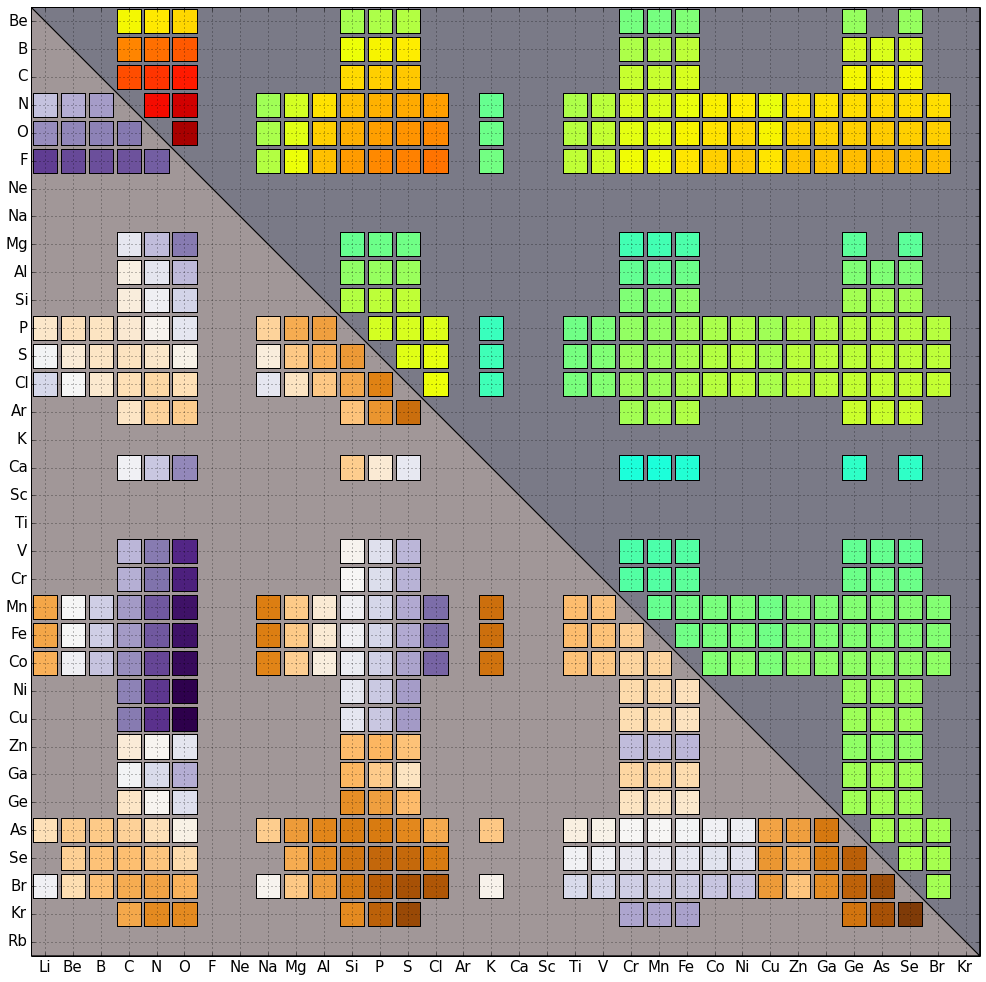

In [52]:
%matplotlib inline
hinton.hinton_2D(Tol_grid,HHIp_grid,Eg_grid,HHIr_grid,maxweight=2)

mpl.pyplot.xticks(np.arange(0.5,(upper_n-lower_n)+0.5),element_set[0::1])
# Reverse the order of the tick labels for the y axis
element_set.reverse()
mpl.pyplot.yticks(np.arange(0.5,(upper_n-lower_n)+0.5),element_set[0::1])
# Revert the order of ticks back to normal
element_set.reverse()
plt.tick_params(axis='both', which='major', labelsize=15)
plt.axis('on')
plt.grid(True)
plt.axes = plt.gca()
plt.axes.set_xlim([0,upper_n-lower_n])
plt.axes.set_ylim([0,upper_n-lower_n])
fig = plt.gcf()
fig.set_size_inches(17,17)
fig = plt.gcf()

plt.savefig('Eg-Tol.eps',dpi=300)

### Plot a 2D grid of the HHI resource and the tolerance factor

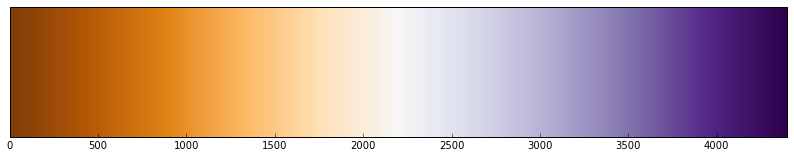

34


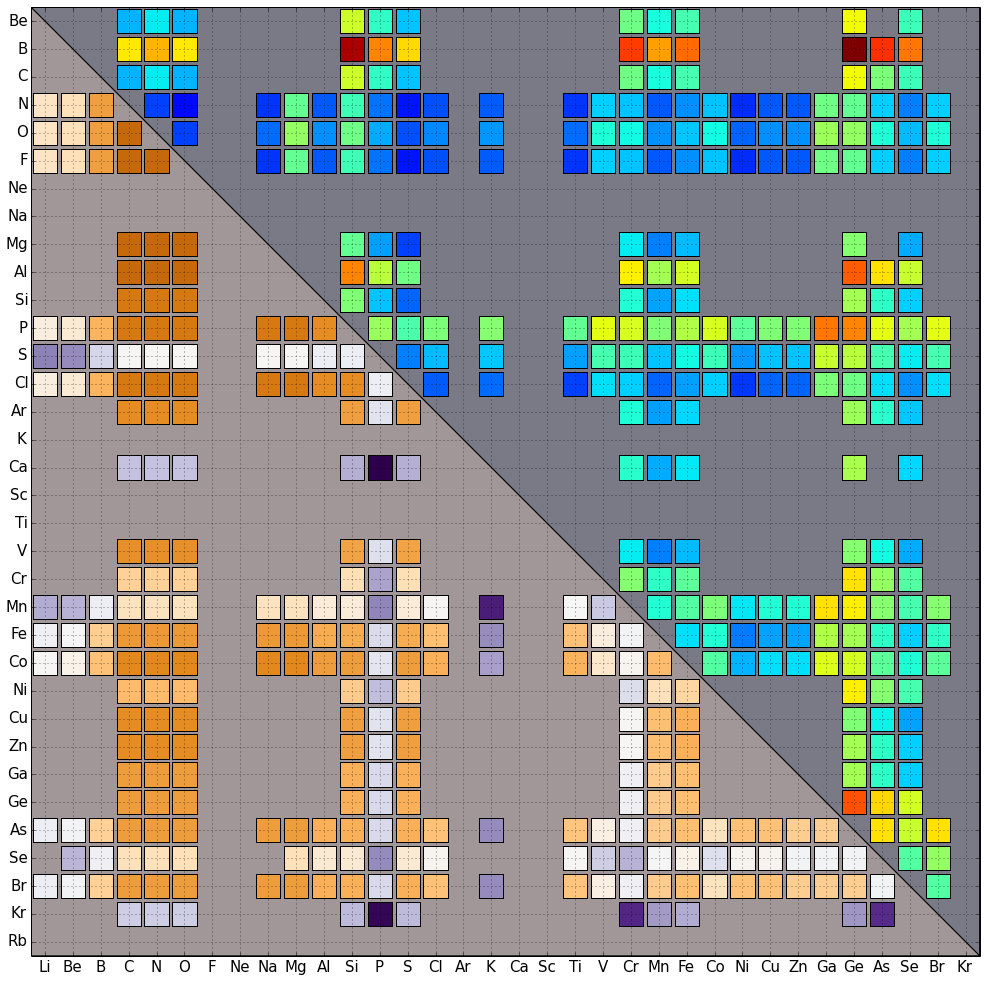

In [53]:
hinton.hinton_2D(HHIp_grid,Tol_grid,HHIr_grid,Eg_grid,maxweight=2)
mpl.pyplot.xticks(np.arange(0.5,(upper_n-lower_n)+0.5),element_set[0::1])
# Reverse the order of the tick labels for the y axis
element_set.reverse()
mpl.pyplot.yticks(np.arange(0.5,(upper_n-lower_n)+0.5),element_set[0::1])
# Revert the order of ticks back to normal
element_set.reverse()
plt.tick_params(axis='both', which='major', labelsize=15)
plt.axis('on')
plt.grid(True)
plt.axes = plt.gca()
plt.axes.set_xlim([0,upper_n-lower_n])
plt.axes.set_ylim([0,upper_n-lower_n])
fig = plt.gcf()
fig.set_size_inches(17,17)
fig = plt.gcf()
plt.savefig('HHI.pdf',dpi=600)

### Build one of the interesting compounds using Tim's structure module

In [54]:
A = smact.Element('Cs')
B = smact.Element('K')
C = smact.Element('Se')
sr = [A.covalent_radius,B.covalent_radius,C.covalent_radius]
cell = lattice_parameters.stuffed_wurtzite(sr)
system = crystal(['Cs','K','Se'],basis=[(0., 0., 0.25),(1./3.,2./3.,0.444),(1./3., 2./3., 0)],spacegroup=186,cellpar=cell)
print 'Structure Parameters'
print 'a', system.cell[0]
print 'b', system.cell[1]
print 'c', system.cell[2]

Structure Parameters
a [ 5.27363055  0.          0.        ]
b [-2.63681527  4.56709802  0.        ]
c [  4.61581390e-16   7.99482419e-16   7.53819616e+00]


In [55]:
 io.write_vasp('POSCAR.CsKSe',system)

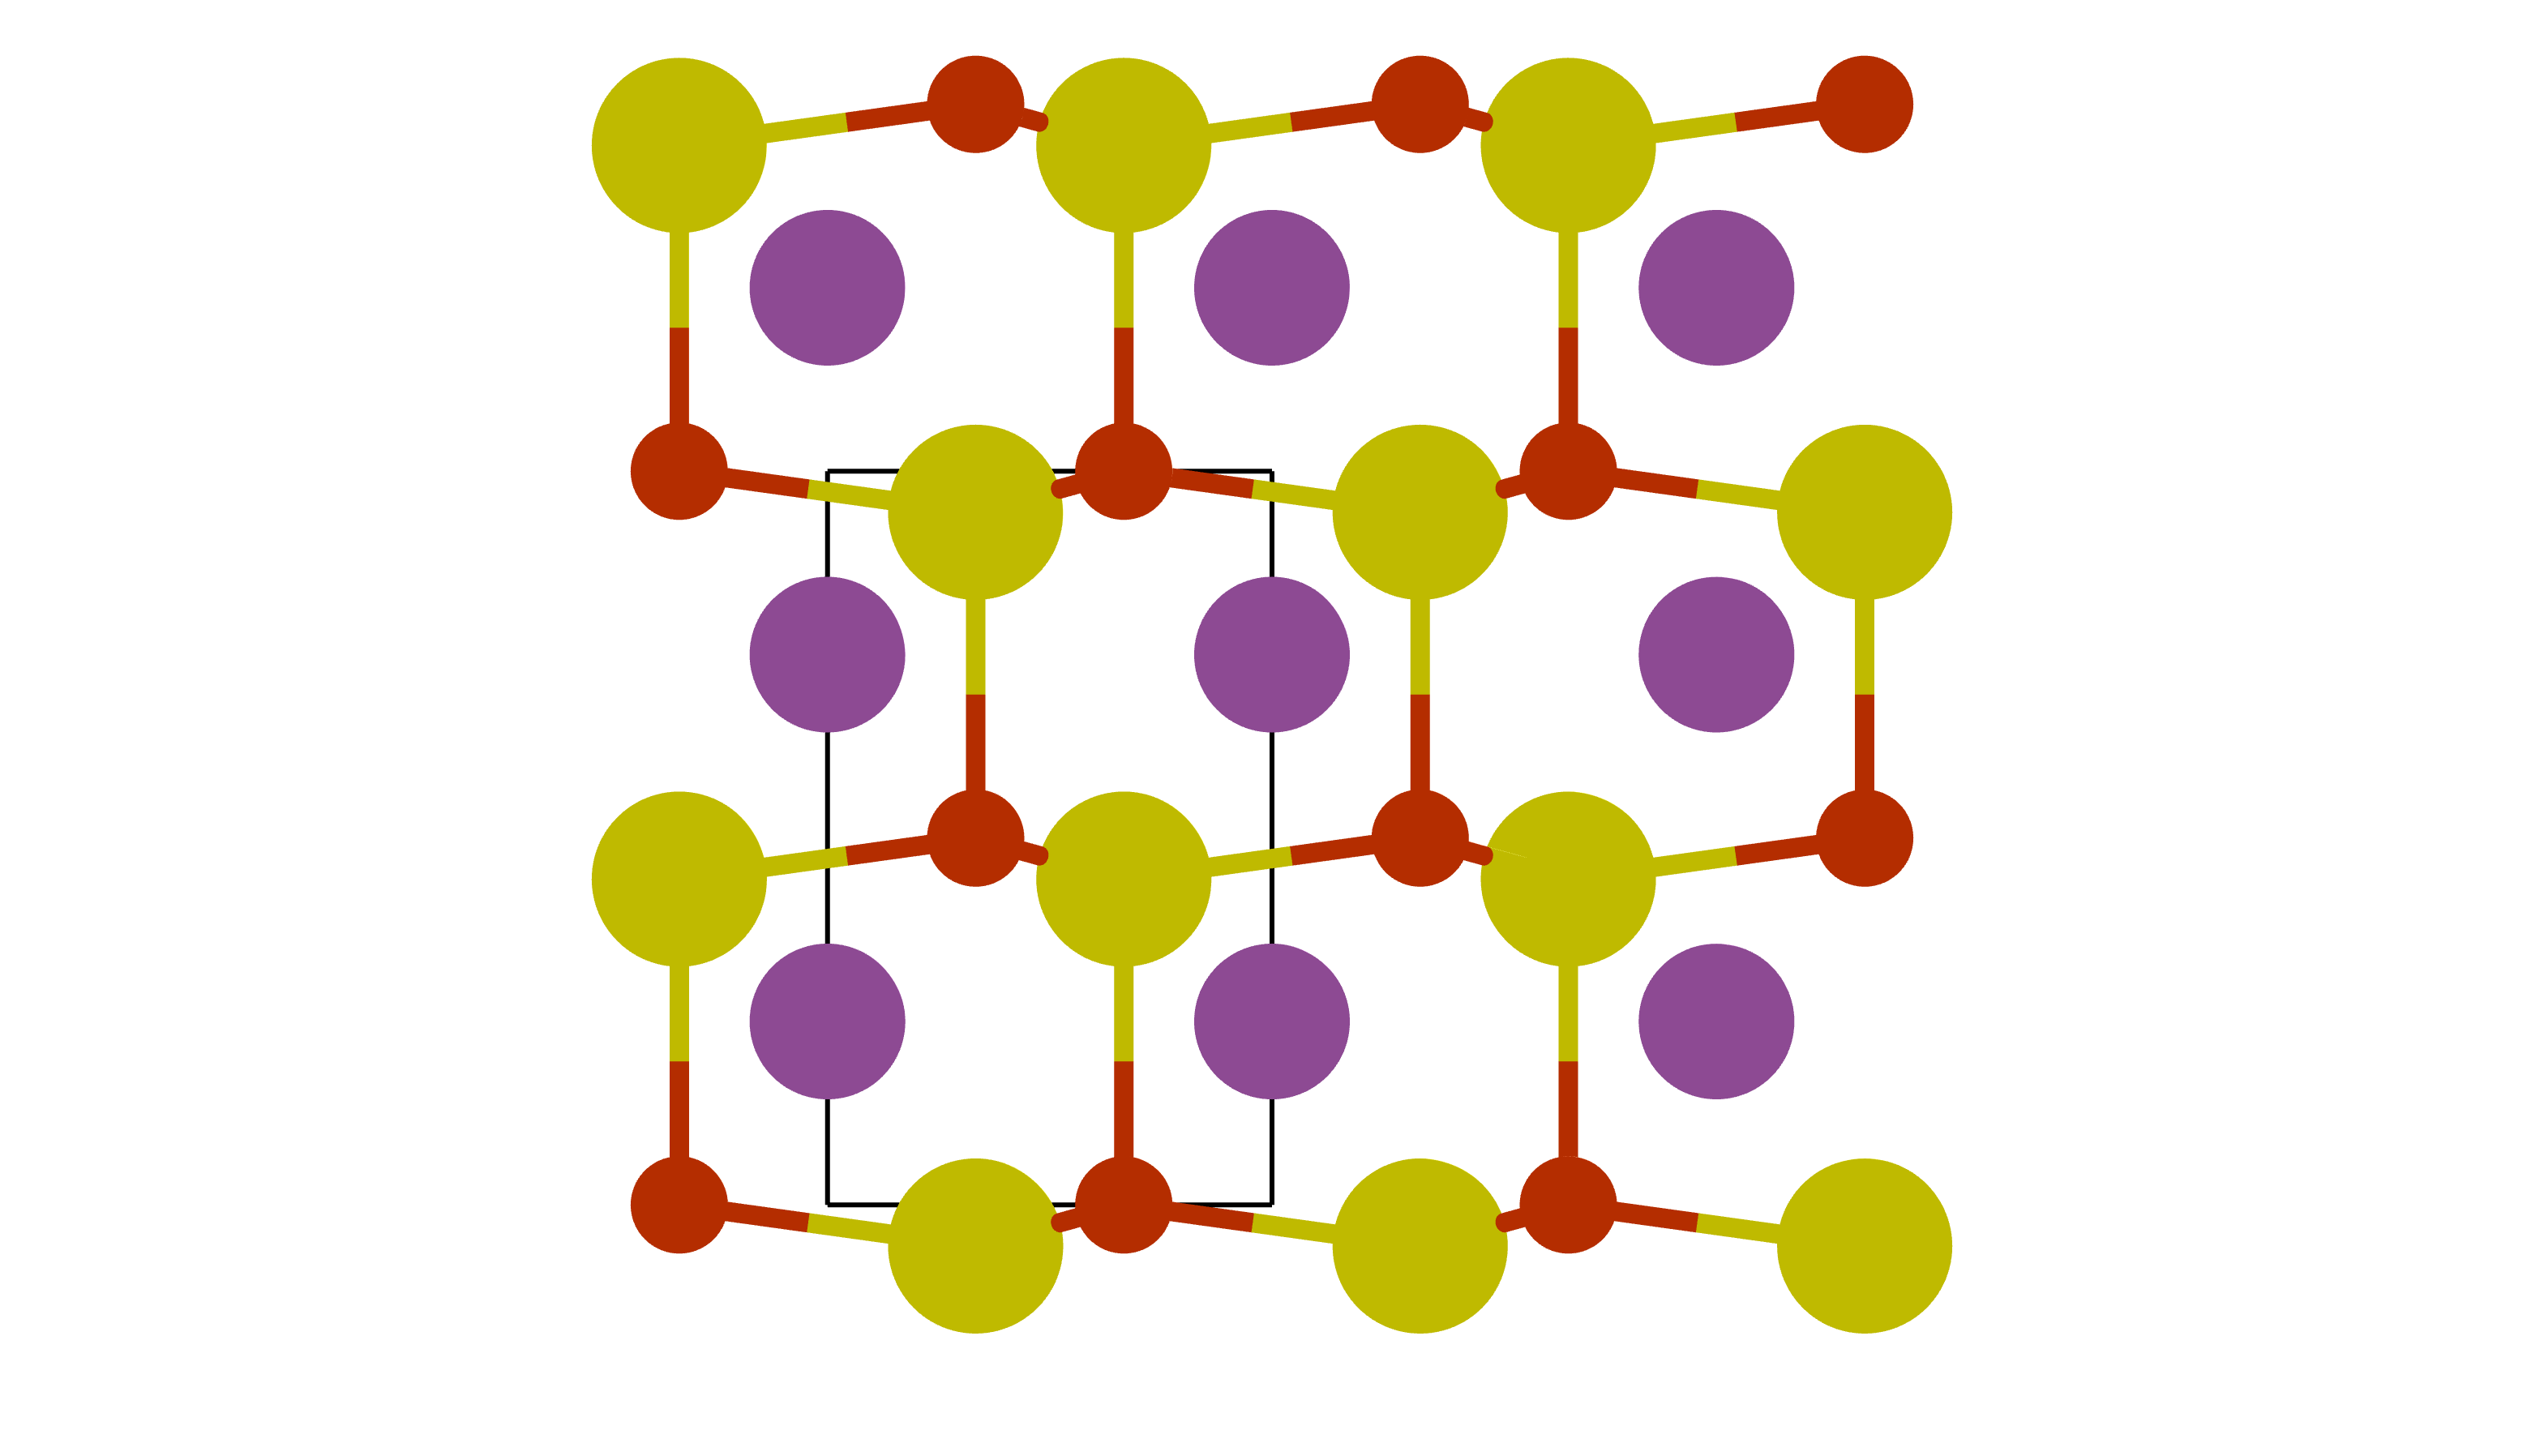

In [56]:
Image('Figures/CsKSe-a.png', width=500)

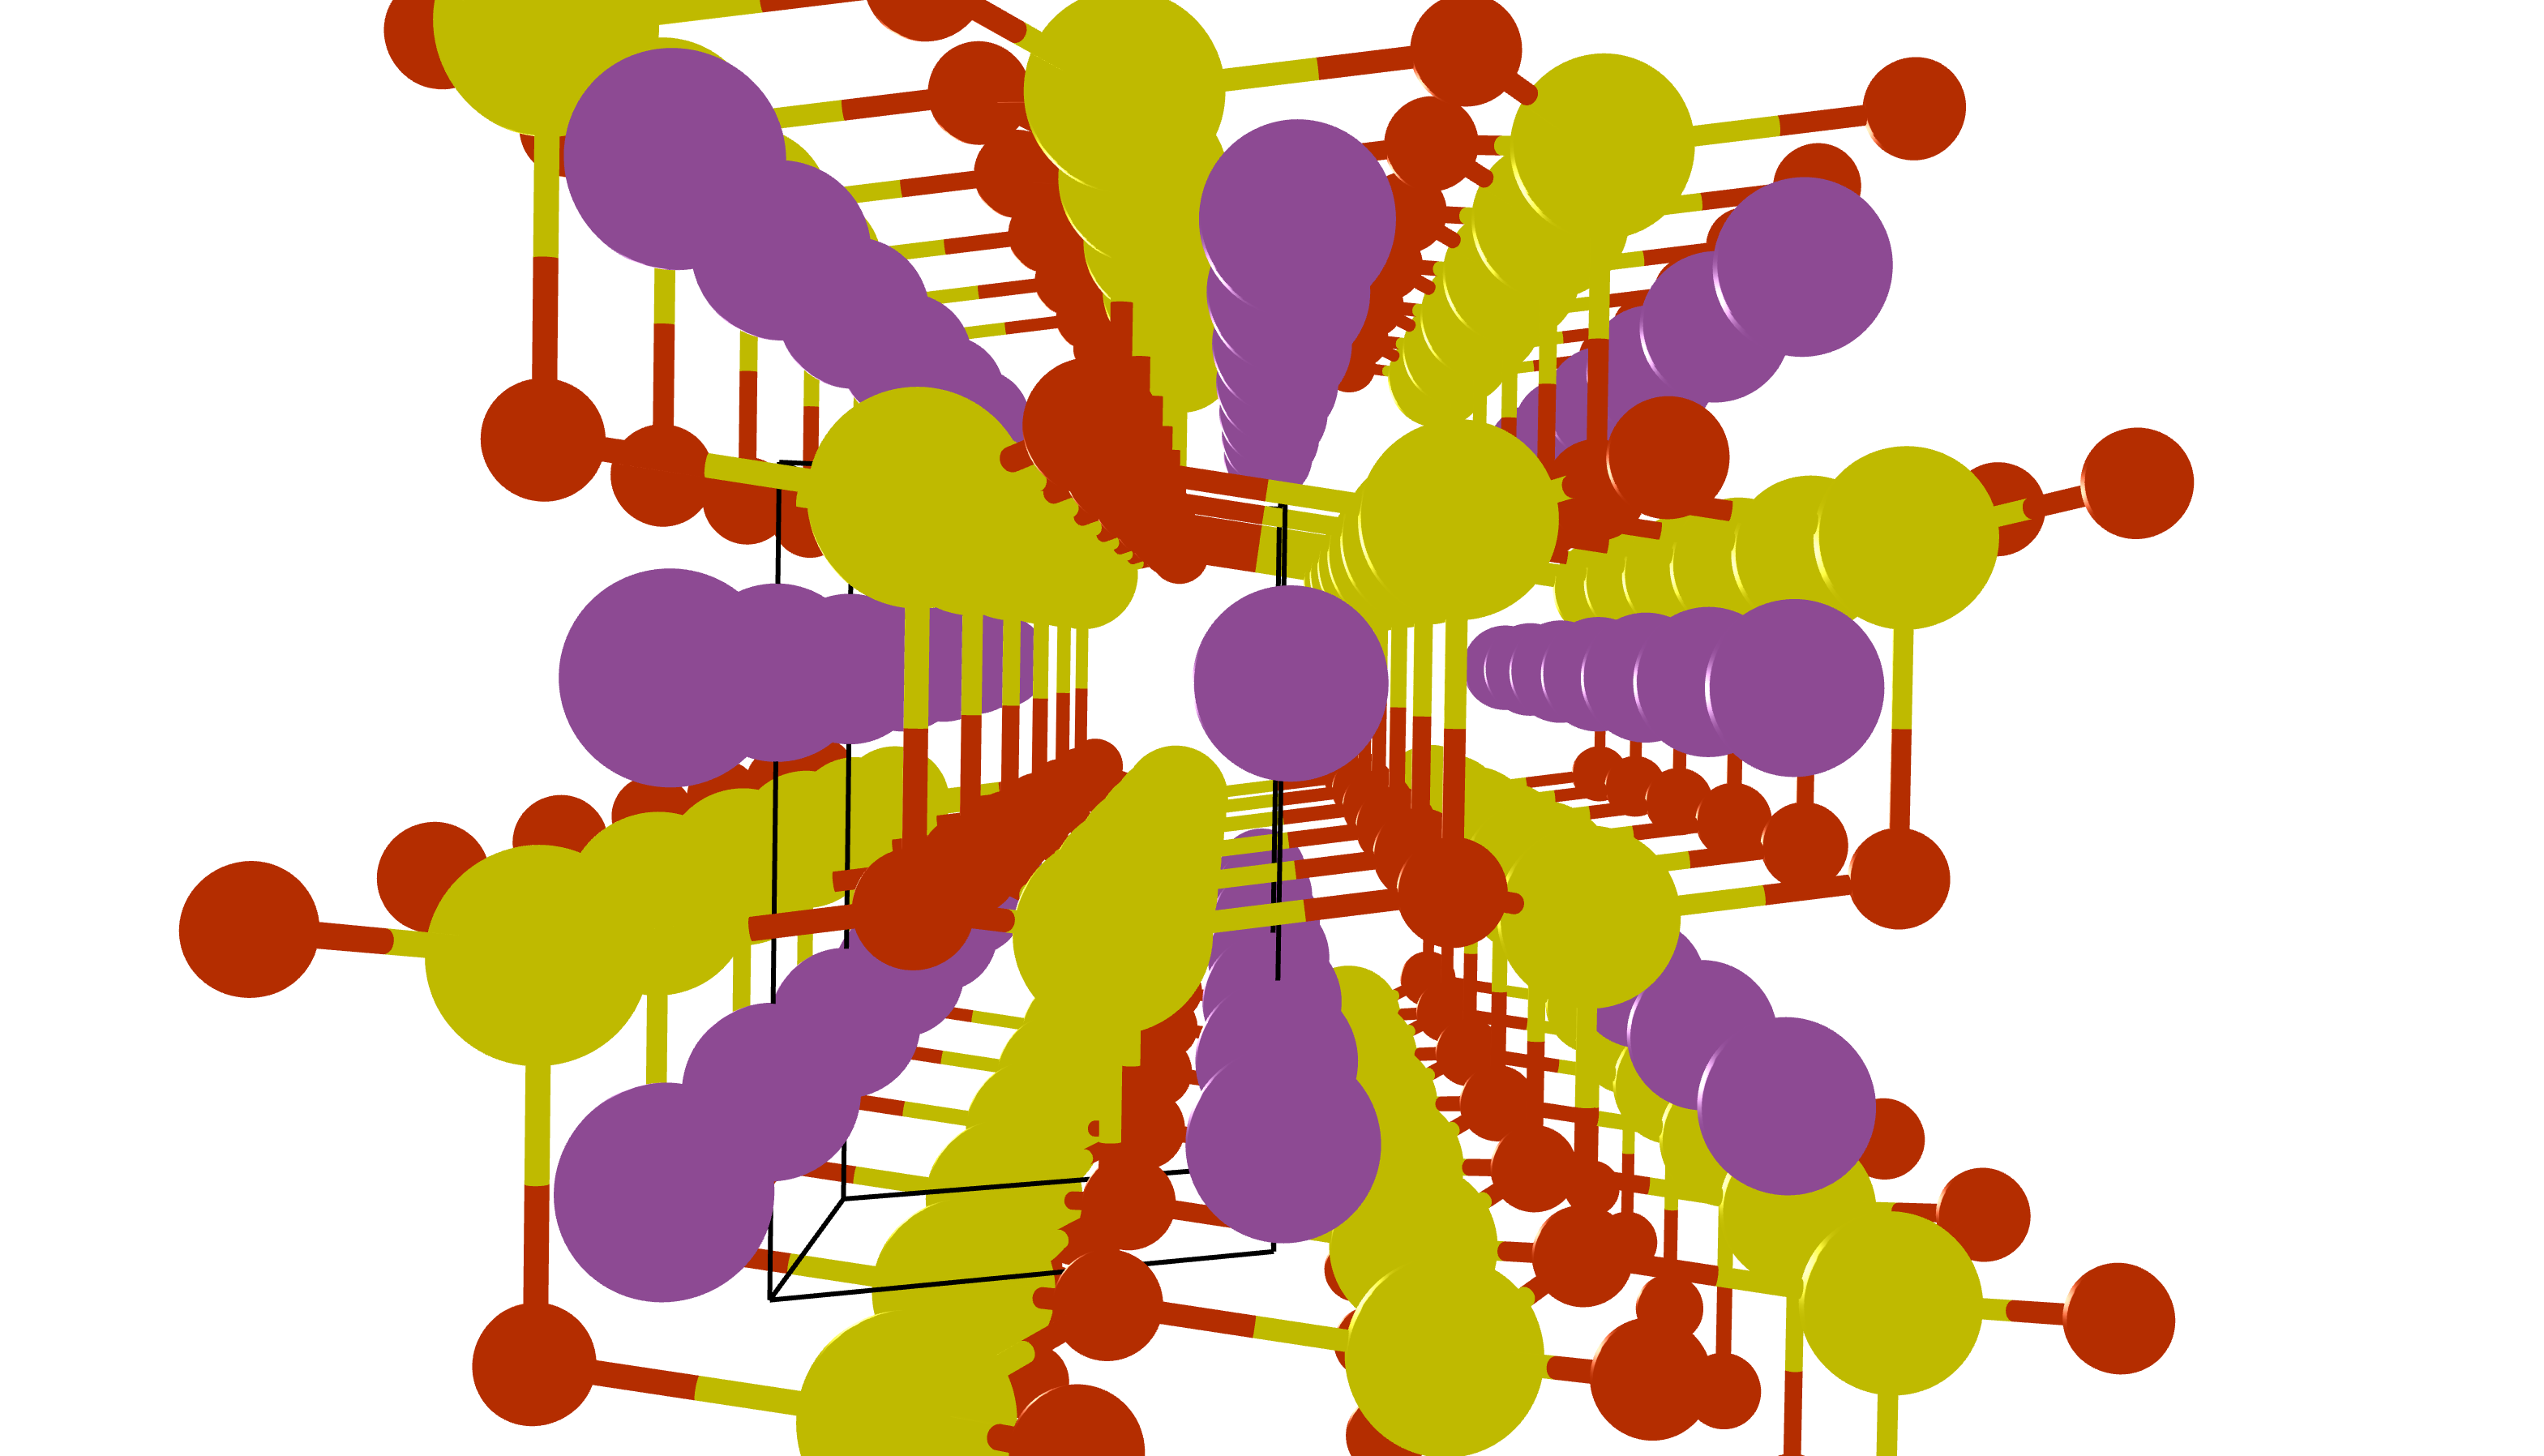

In [57]:
Image('Figures/CsKSe-p.png', width=500)